<a href="https://colab.research.google.com/github/Ana-PPS/data-and-analytcs/blob/MVP_III/MVP_Sprint_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

## MVP Sprint III: Engenharia de Dados

Aluna: Ana Paula Pinheiro Salgado

Setembro/2023

# Objetivo


### **Análise Mercado de Compra e Venda de Energia Elétrica**

Empresa do setor de energia, com baixa penetração no ambiente de comercialização, busca entender onde está inserida e assim estudar potencialidades para ampliar o seu mercado.

Para tanto, utilizando dados disponibilizados pela CCEE (Câmara de Comercialização de Energia Elétrica), relacionados aos contratos de compra e venda de energia, busca-se responder as seguintes perguntas:

1. Qual o montante médio total comercializado por ano?
2. Quem são os 10 maiores agentes e qual a fatia de mercado que absorvem?
3. Como tem variado o índice de participação de mercado dos top10 agentes ao longo dos últimos 4 anos?



# Detalhamento

## Busca pelos dados

Os datasets foram construídos a partir de planilhas eletrônicas obtidas no site da CCEE, disponibilizadas no endereço https://www.ccee.org.br/web/guest/dados-e-analises/dados-mercado-mensal, especificamente no bloco de informação de Dados Individuais (exemplo do último dado disponível https://www.ccee.org.br/documents/80415/25552621/InfoMercado_Dados_Individuais-jul2023.xlsx/5cc2ba8f-a612-0bcf-eaea-3fe82335fa98, consulta feita em 12/09/2023)


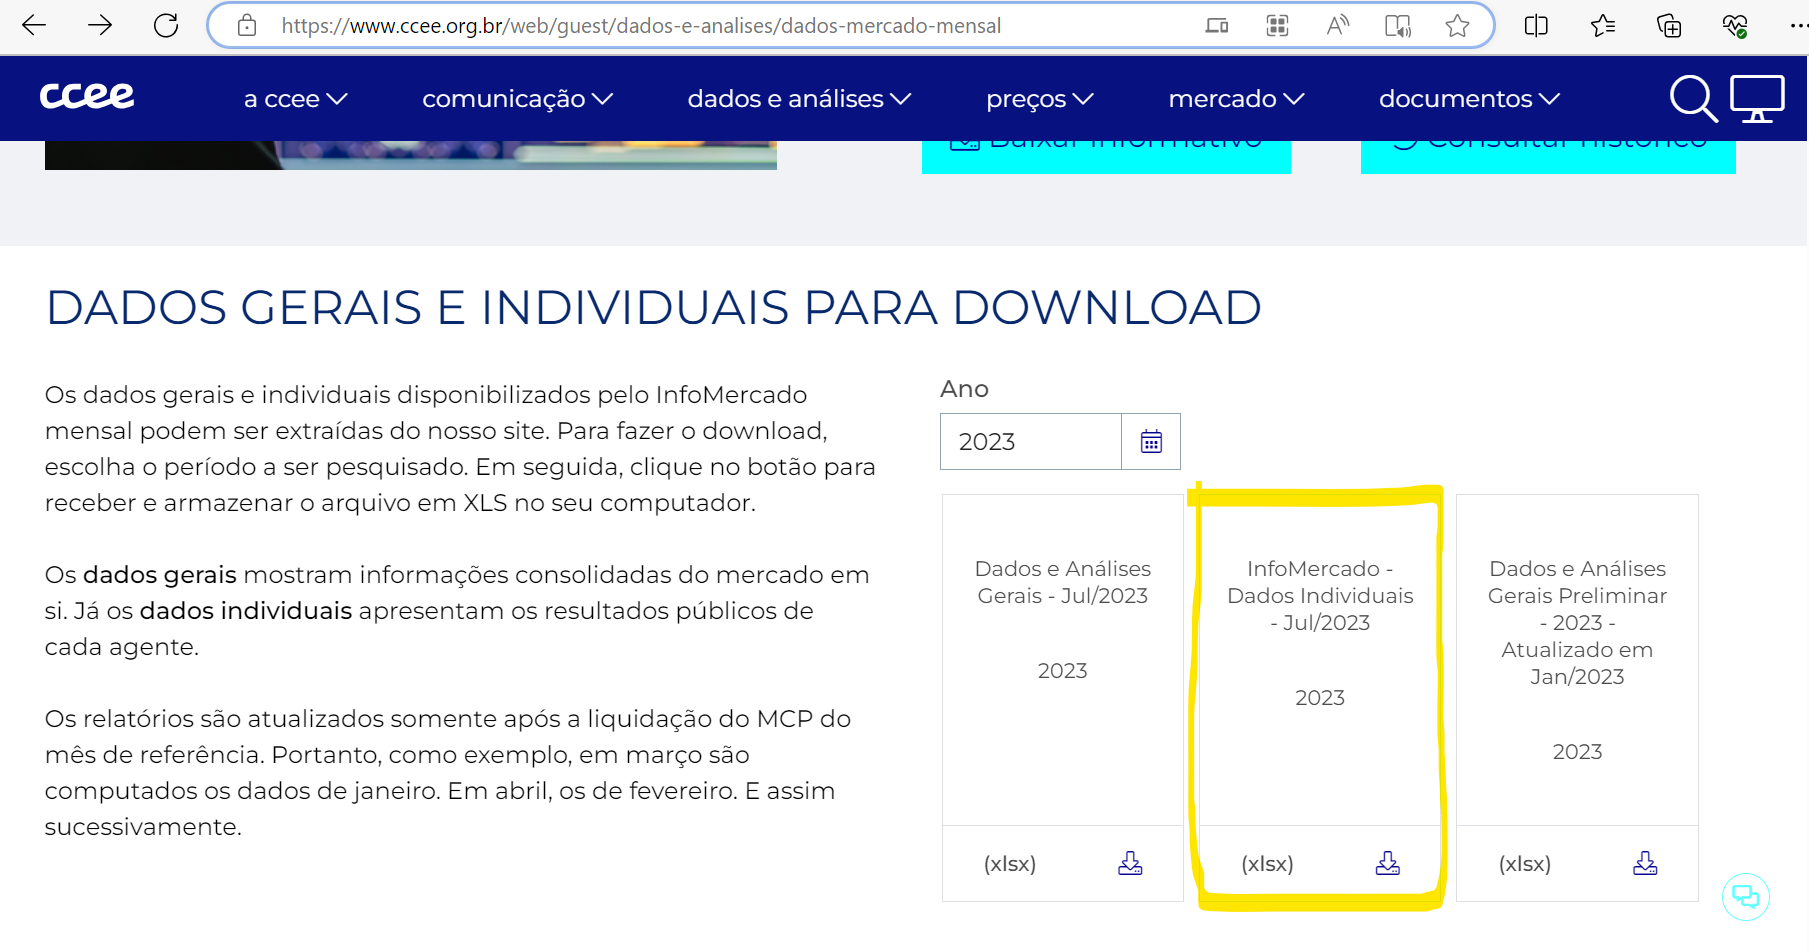![image.png]()



As planilhas, em formato excel, foram originalmente baixadas para uma pasta de armazenamento local. Dela foram extraídas as tabelas correspondentes ao Volume de Contratação Mensal de Vendas (Tabela 001) e Compras (Tabela 002), da aba 001 Contratos.

Adicionalmente, também foram coletados os dados dos Perfis dos Agentes (Tabela 001), da aba 007 Lista de Perfis, para poder fazer o cruzamento entre as tabelas e possibilitar a execução das análises que irão fornecer as respostas construídas no tópico Objetivo deste MVP.

Os relatórios do InformercadoCCEE são atualizados somente após a liquidação do MCP (Mercado de Curto Prazo) do mês de referência. Portanto, como exemplo, em setembro são computados os dados de julho.

A CCEE iniciou em 2023 a migração dos dados para um Portal de Dados Abertos, no entanto, até o momento não estão disponíveis as informações individualizadas por agente, e tampouco por períodos anteriores a Maio/2023, que é o escopo abarcado por este MVP.

## Coleta

Os dados, de origem de pasta local, foram inseridos manualmente no Armazenamento de Blob do Azure, em pasta nomeada como _mvpdadosccee_, no subdiretório _raw_ e subdiretórios correspondentes.

As imagens a seguir resumem a sequência dos armazenamentos de origem:


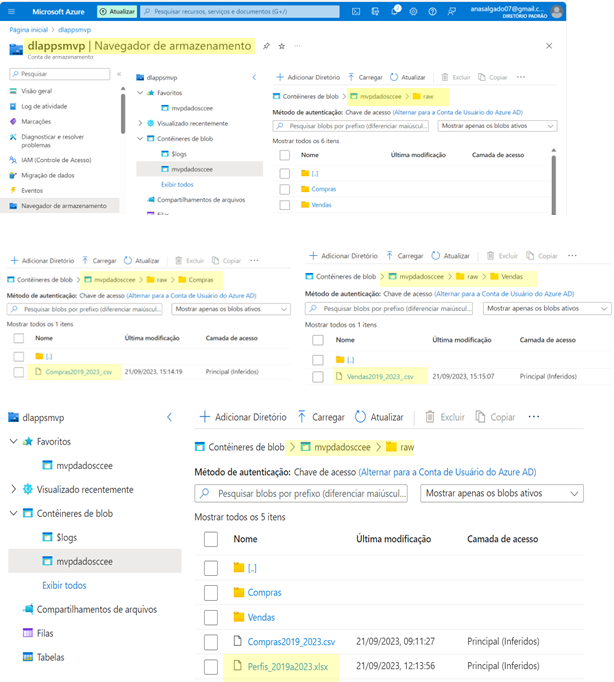





*   O arquivo Compras2019_2023.csv, com dados dos contratos de compra de energia elétrica, contabilizados de Janeiro/2019 a Julho/2023
*   O arquivo Vendas2019_2023.csv, com dados dos contratos de venda de energia elétrica, contabilizados de Janeiro/2019 a Julho/2023
* O arquivo Perfis_2019a2023.csv, que reúne os dados dos agentes cadastrados na CCEE, com contabilizações registradas no período.





Posteriormente, por meio de um serviço vinculado, no caso deste MVP, nomeado como _AzureBlobStorage1_, foram criados Conjunto de Dados, com os arquivos armazenados no contêiner de blob descrito acima, para uso posterior nos fluxos de dados da etapa de Modelagem e Carga.


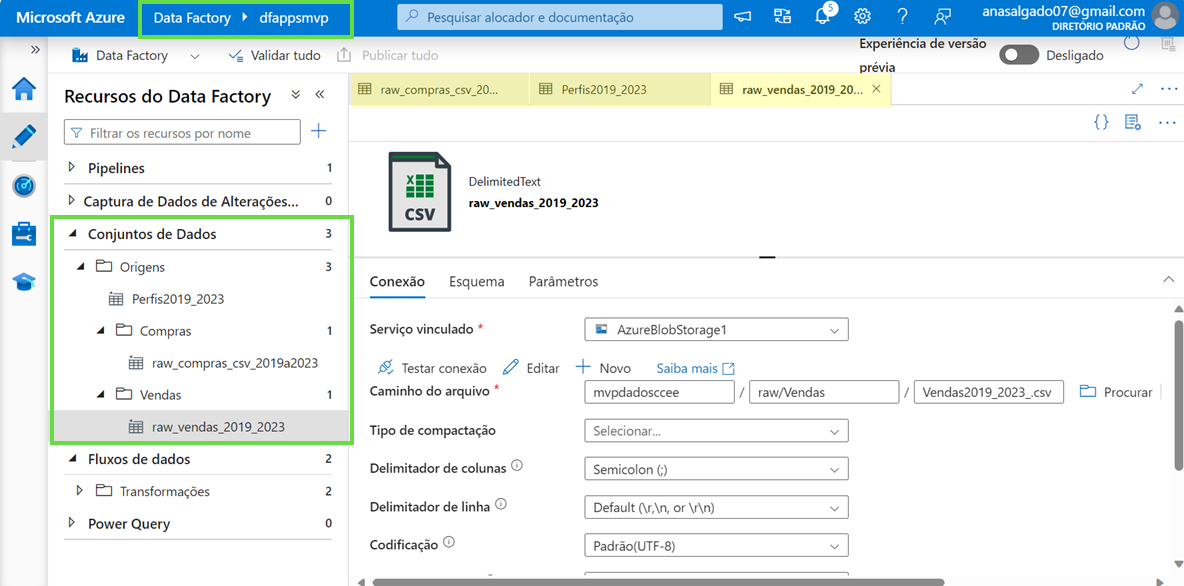

## ETL

Através da interface visual do Data Factory Azure foi definido um fluxo de atividades para execução da **Extração** dos dados da fonte, no caso o armazenamento de Blob do Azure, pasta e subpastas _raw_ do contâiner _mvpdadosccee_, **Transformações** diversas, detalhadas mais adiante e **Carga** dos dados transformados para a pasta de destino _refined_, do contâiner _mvpdadosccee_, do armazenamento de Blob do Azure.

Para essa etapa foram criados 02 (dois) fluxos de dados para trabalhar com os arquivos que comporão a tabela "Fato", *fCompra_venda* e a tabela "Dimensão", *dimPerfis*.

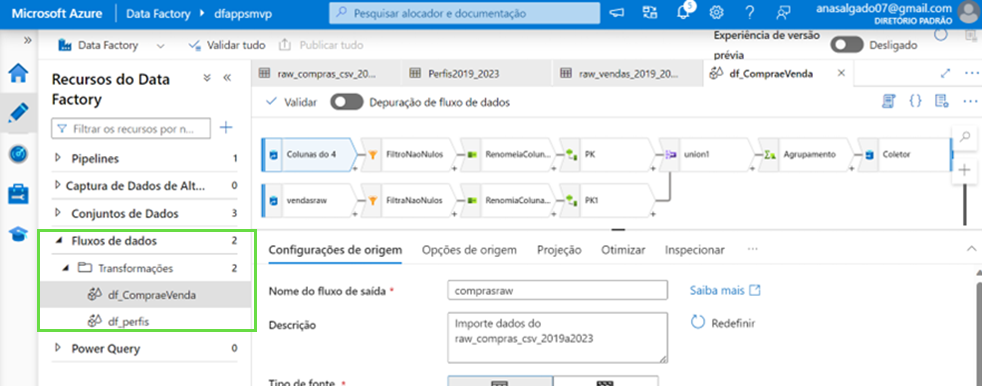

### df_CompraeVenda

Esse fluxo tem início conectando-se, separadamente, aos conjuntos de dados nomeados _raw_compras_csv_2019a2023_ e _raw_vendas_2019_2023.

Obs.: As etapas de 1 a 4 do fluxo são idênticas para ambas as origens, portanto as imagens ilustrativas exemplificam apenas um dos conjuntos de dados.

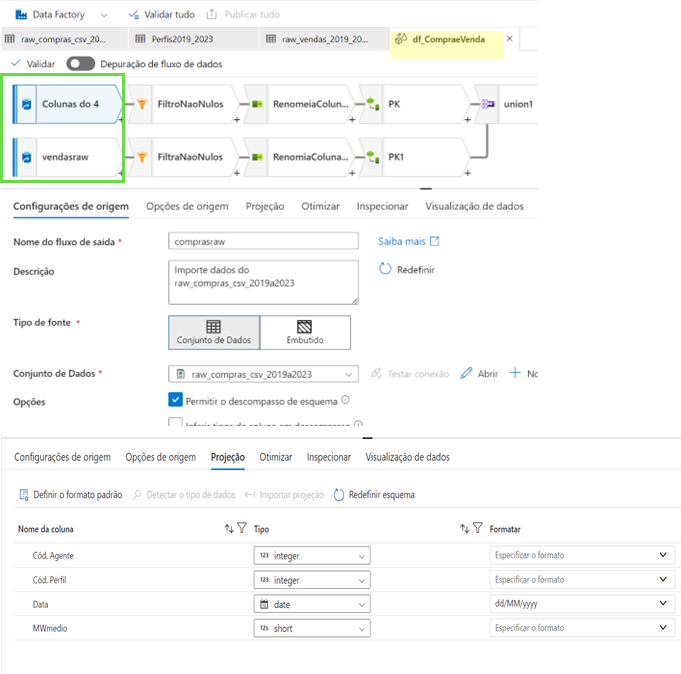

Na sequência é adicionada uma etapa de filtro nas colunas de valores de _MWmedio_ para manter apenas as linhas com valores Não Nulos.

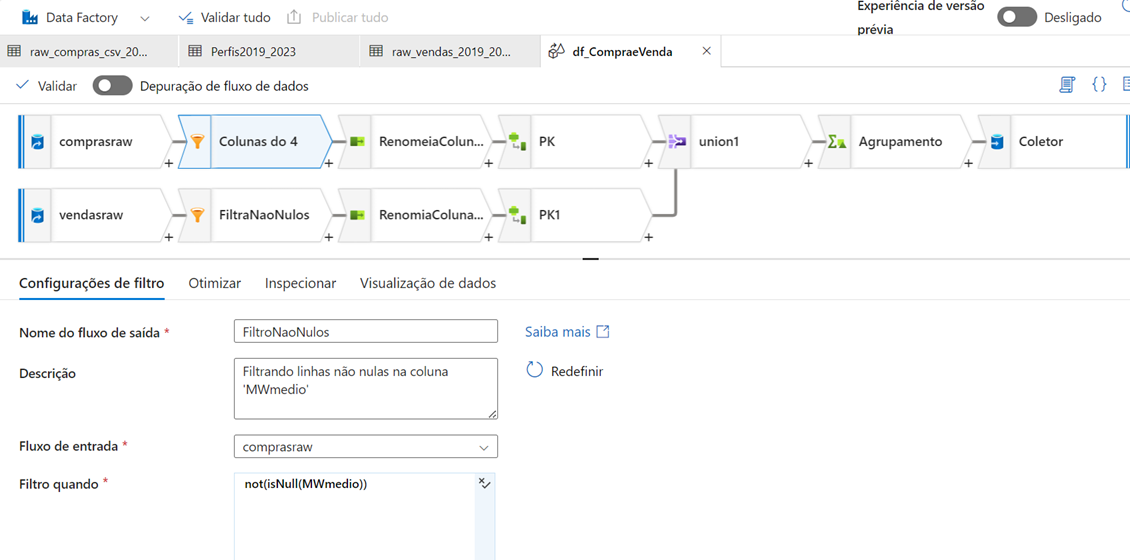

A etapa seguinte renomeia a coluna de MWmedio, para Compras MWmedio e Vendas MWmedio, respectivamente, para fins de adequada identificação após a junção dos conjunto de dados.

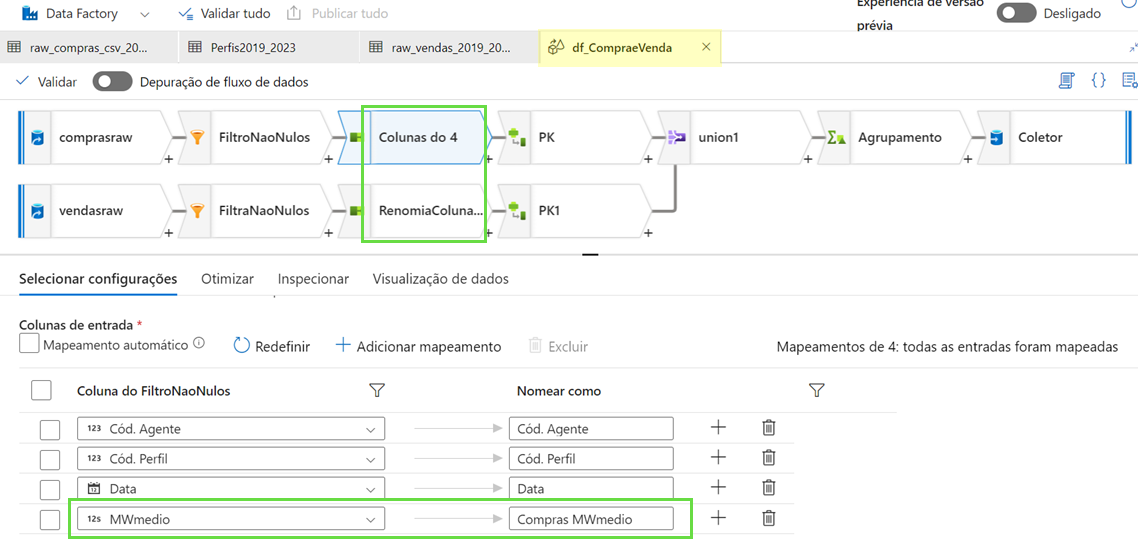


Na sequência foi inserida uma etapa de "ColunaDerivada", com o objetivo de criar uma chave primária para cada um dos conjuntos de dados, unindo as colunas _Cód.Agente_ e _Cód. Perfil_.

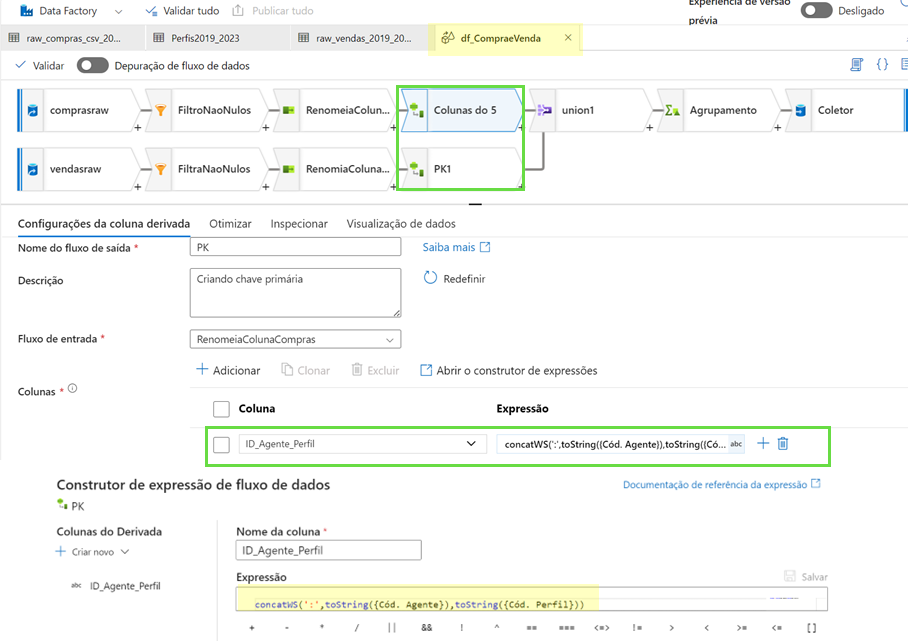

A próxima etapa unifica os dois conjuntos de dados em uma única tabela.

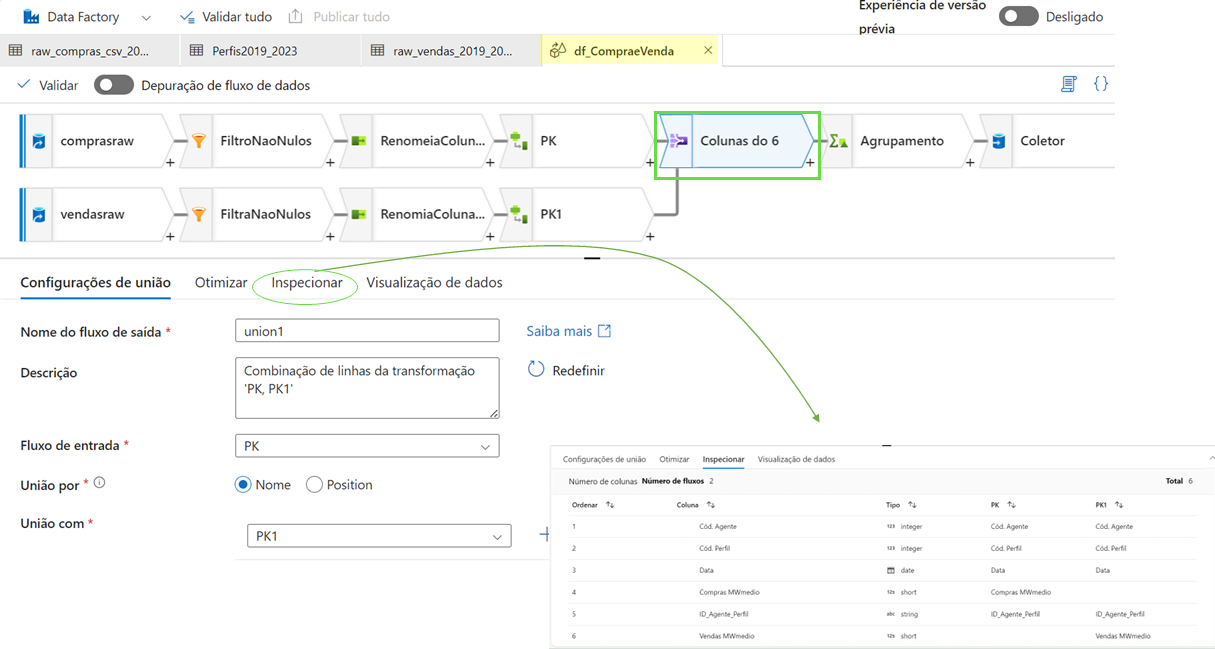

A penúltima etapa executa o agrupamento das colunas de Compras MWmedio e Vendas MWmedio, pela PK ID_Agente_Perfil e por data.

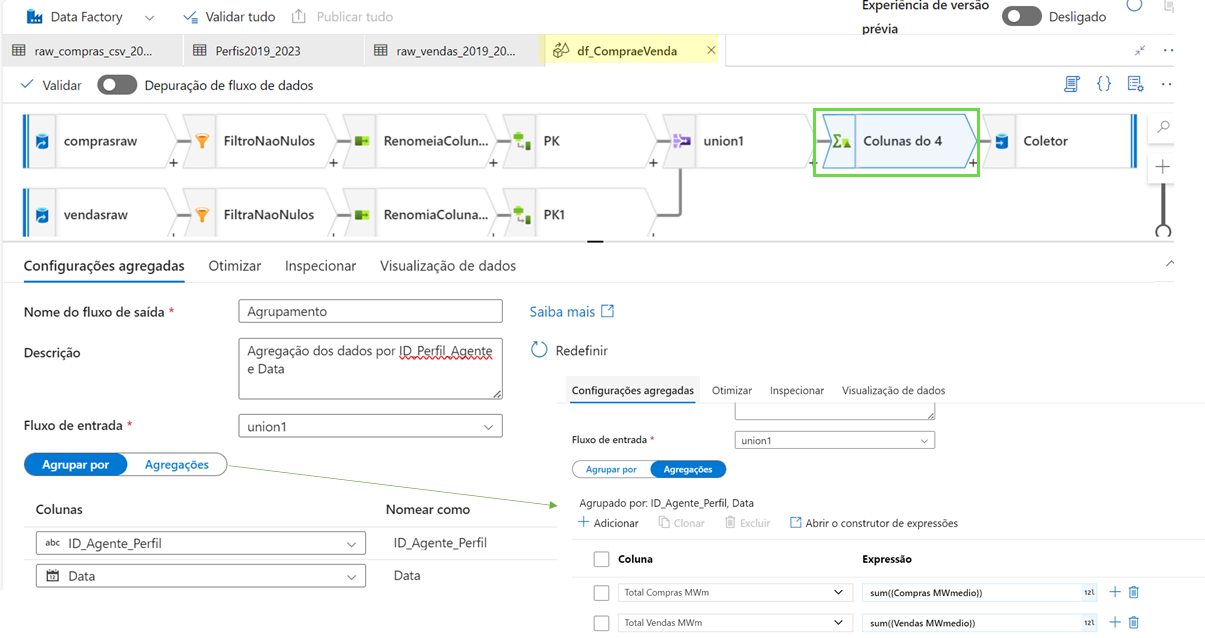

Por fim, a última etapa executa a coleta do novo conjunto de dados gerado por este fluxo, para o datawarehouse do Azure nominado _refined_.

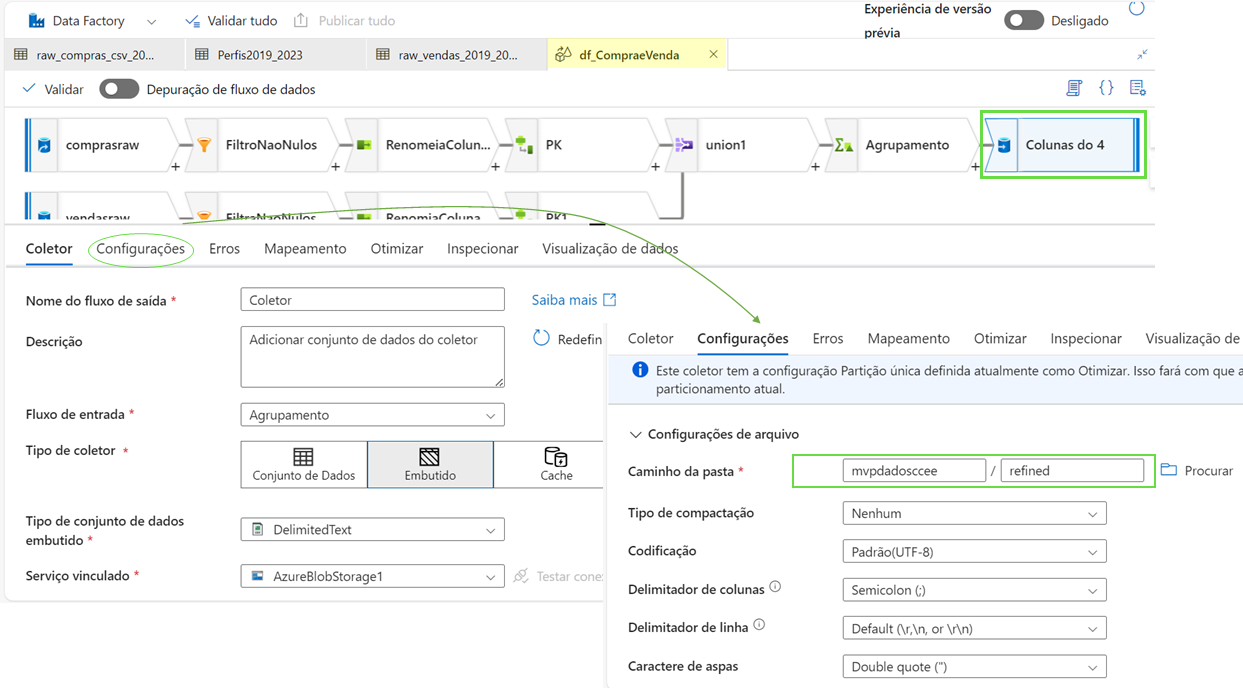

### df_Perfis

Esse segundo fluxo consolida as etapas de busca do arquivo origem no contêiner de Blob do Azure, criação da PK, através da concatenação dos registros das colunas _Cód. Agente_ e _Cód. Perfil de Agente_, a exemplo do que foi demonstrado no fluxo anterior, e a etapa final de coleta da nova tabela de dados no datawarehouse do Azure.


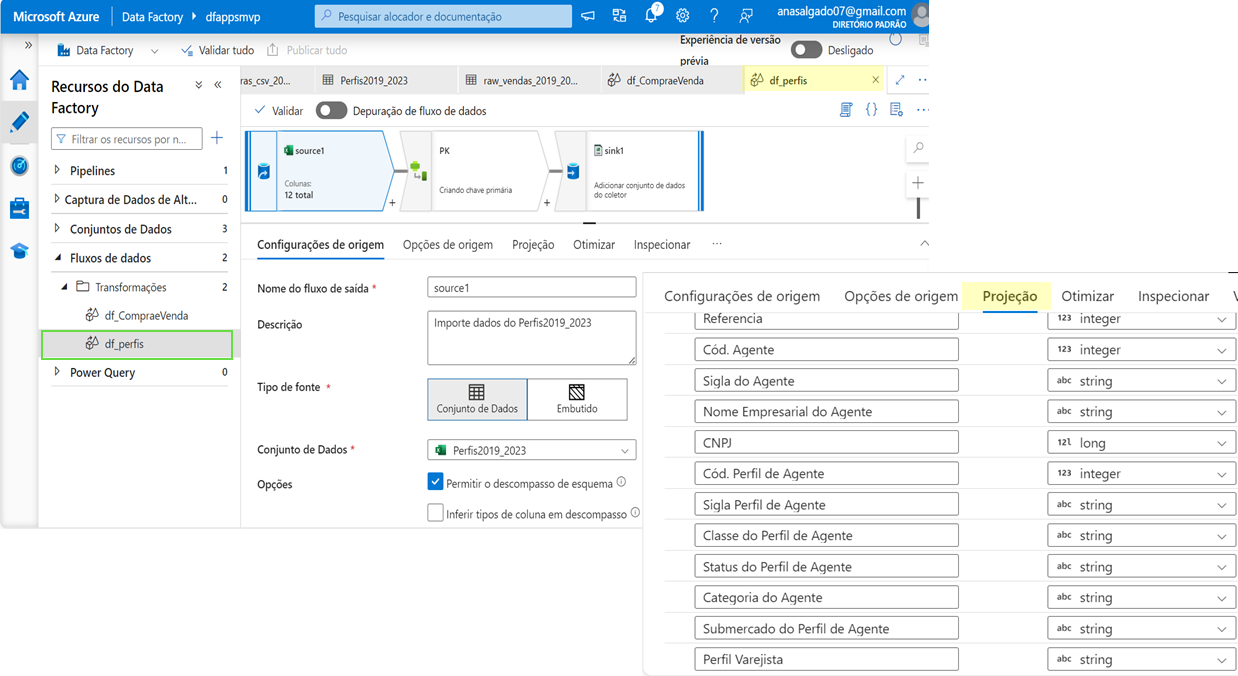

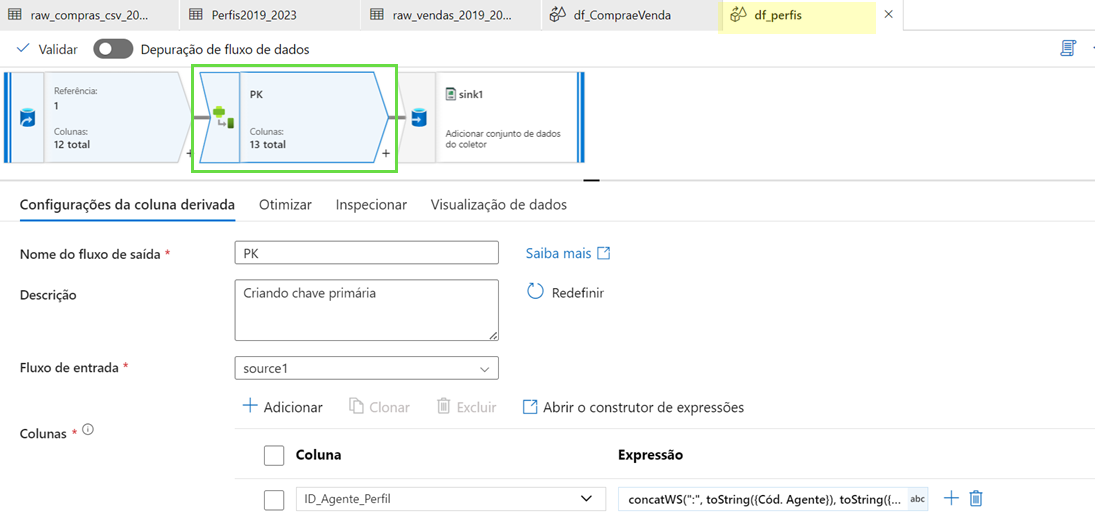

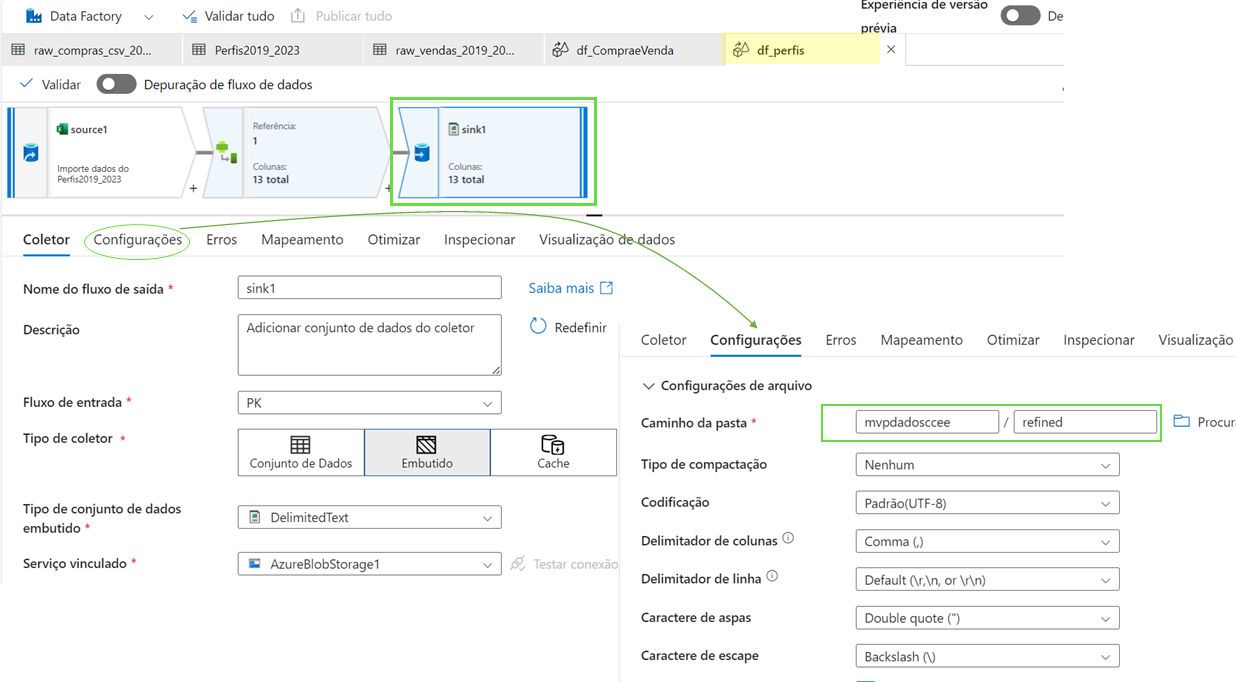

### Pipeline

Os dois fluxos acima foram configurados no pipeline nominado _ETL_ e após a execução satisfatória o datawarehouse recebeu os dois conjuntos de dados transformados nas etapas demonstradas anteriormente.

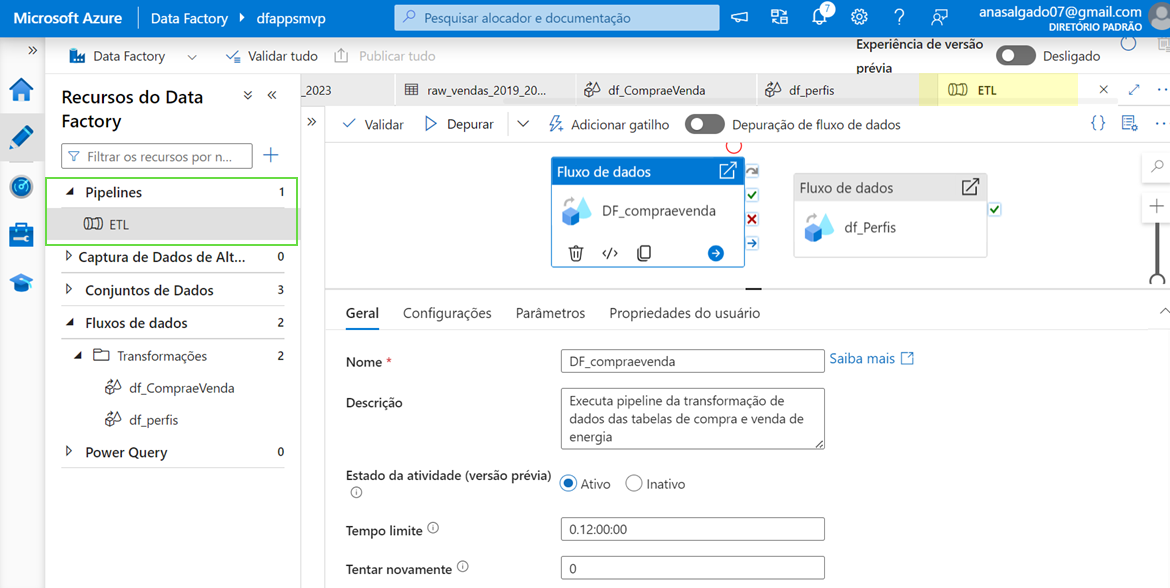

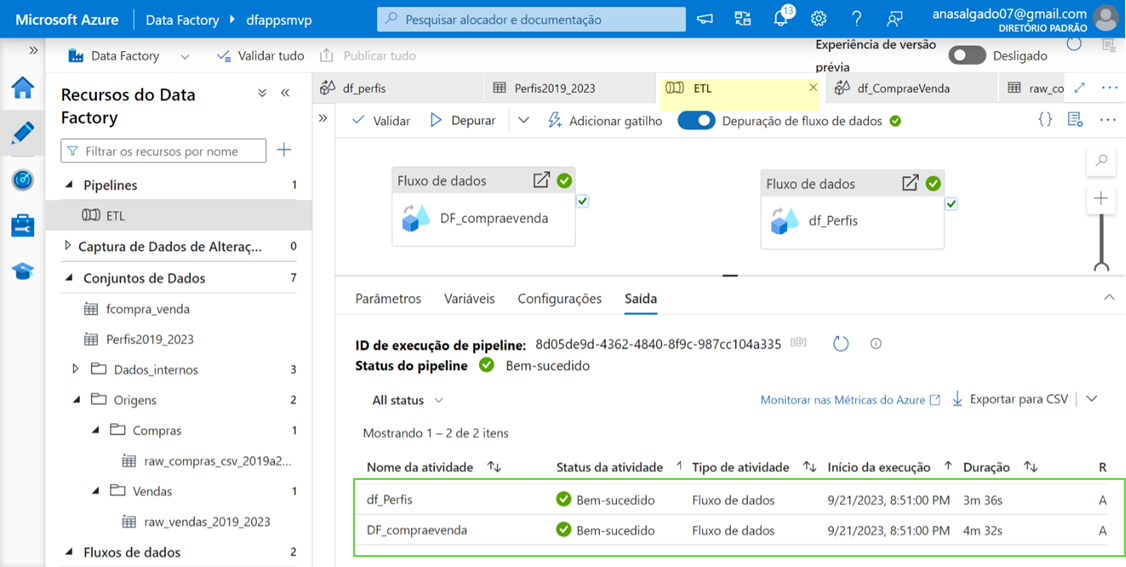

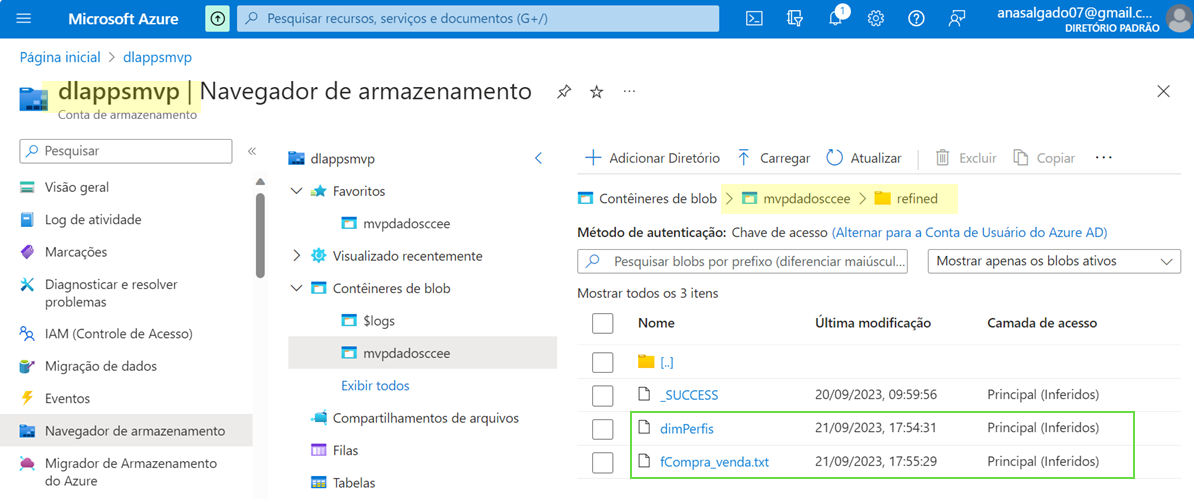

### Catálogo de Dados

As imagens desta seção apresentam a criação do catálogo de dados com a utilização do recurso Microsoft Purview.

O primeiro print apresenta a visualização do Mapa de Dados construído a partir da conexão com o Storage do Azure.

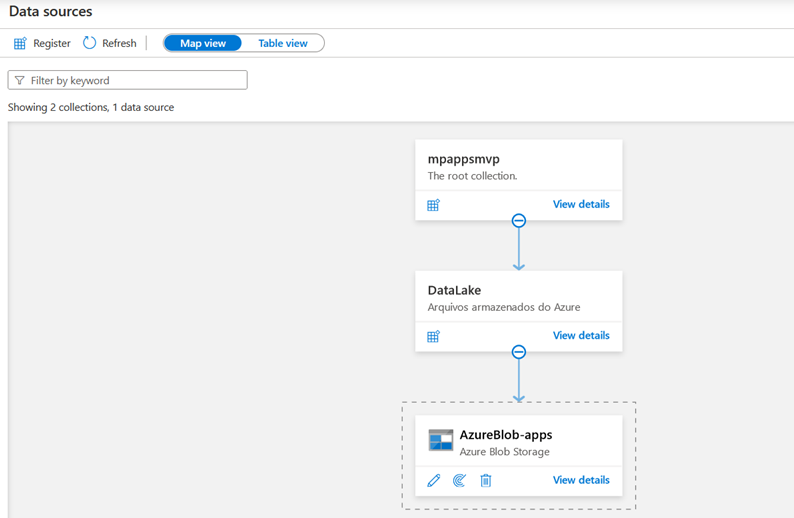

Na sequência, apresenta-se as telas com Propriedades, Linhagem e Catálogo dos Dados das tabelas mapeadas na pasta no datawarehouse *refined*

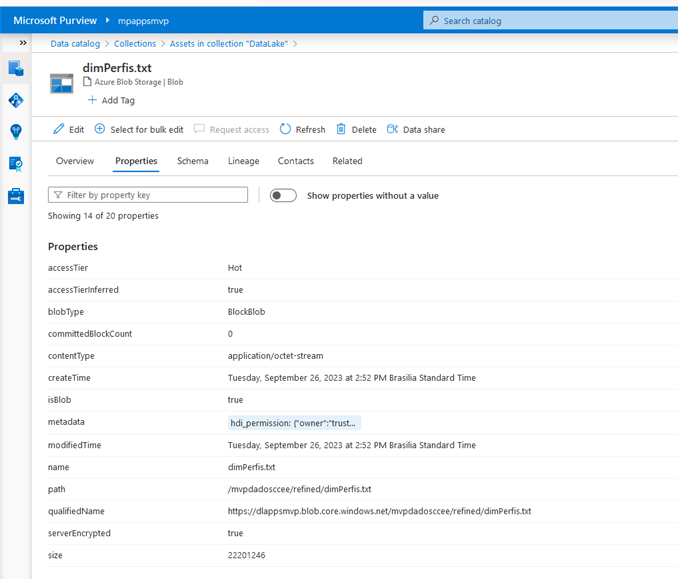

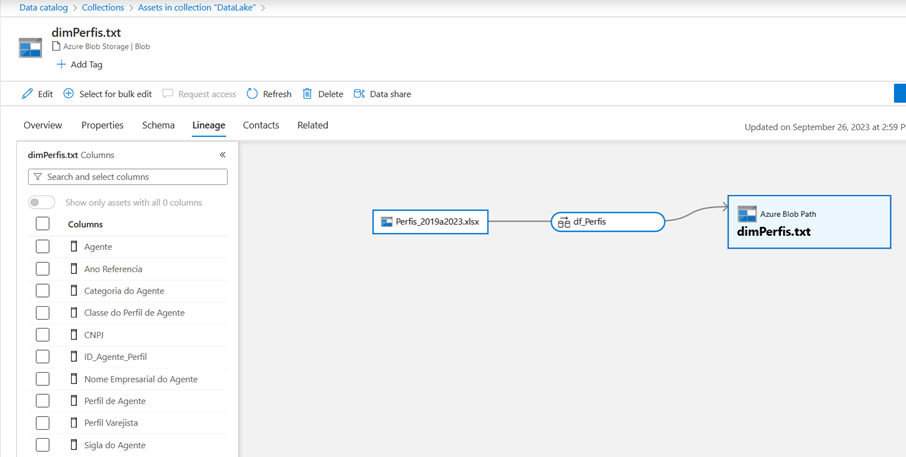

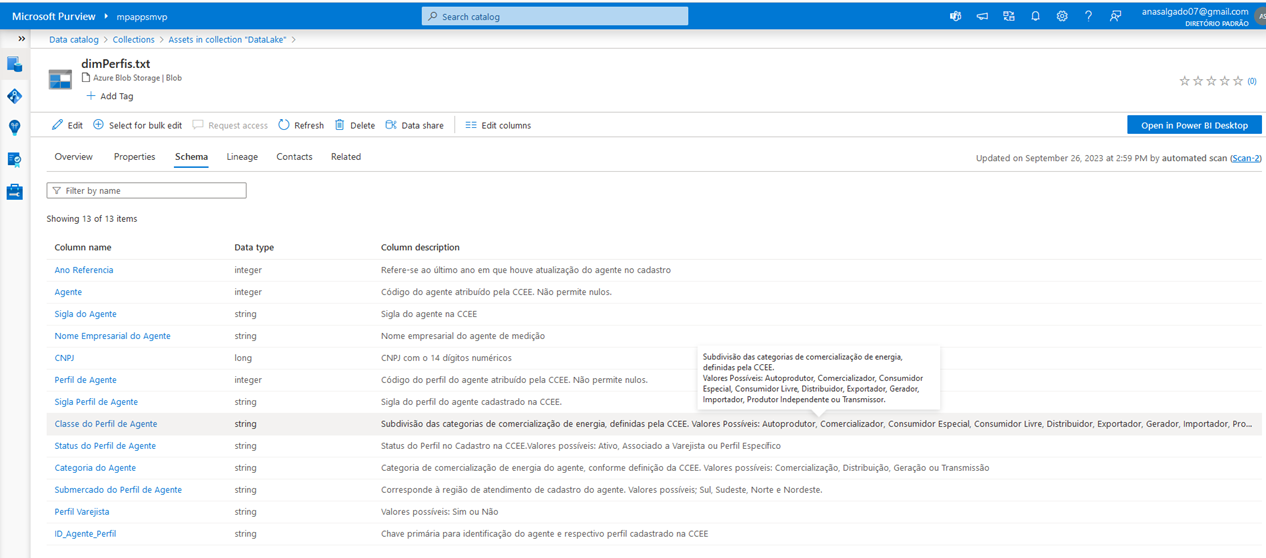

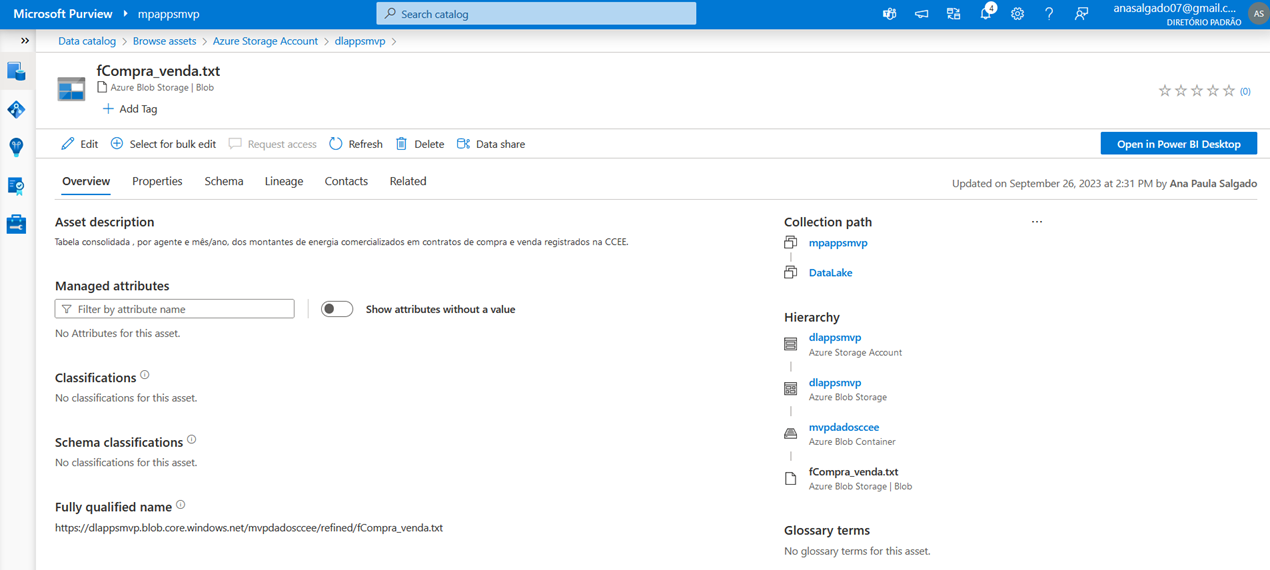

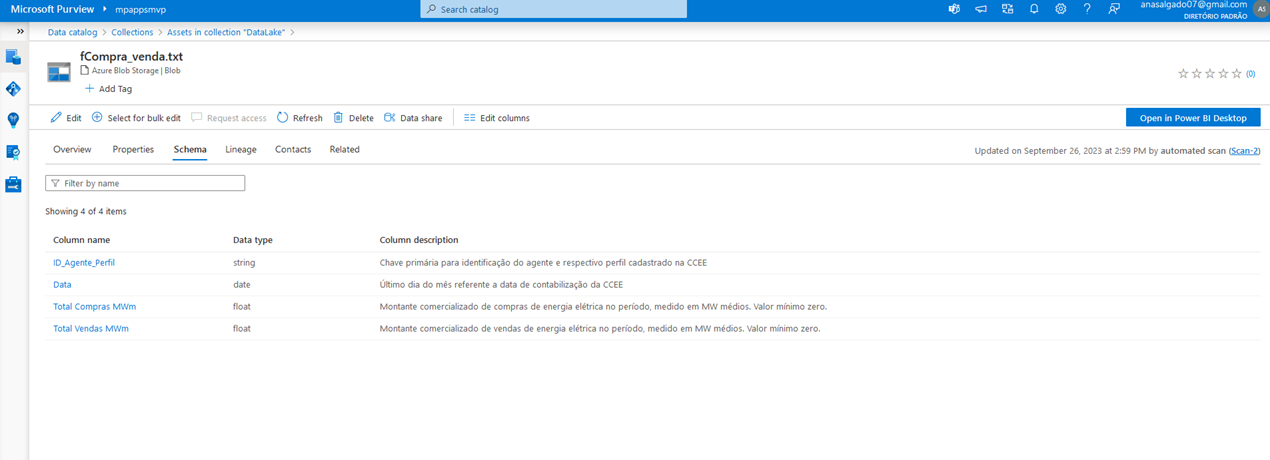

# Análise

Para análise dos dados e obtenção das respostas às perguntas elaboradas na seção Objetivo, optou-se pela utilização do Power BI, conectando-o diretamente ao datawarehouse do Azure indicado nas sessões anteriores.

**Tabela Fato**

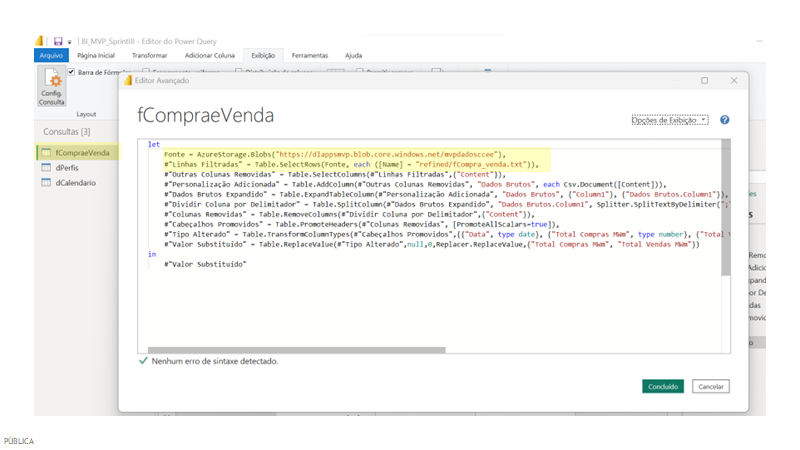

**Tabela Dimensão**

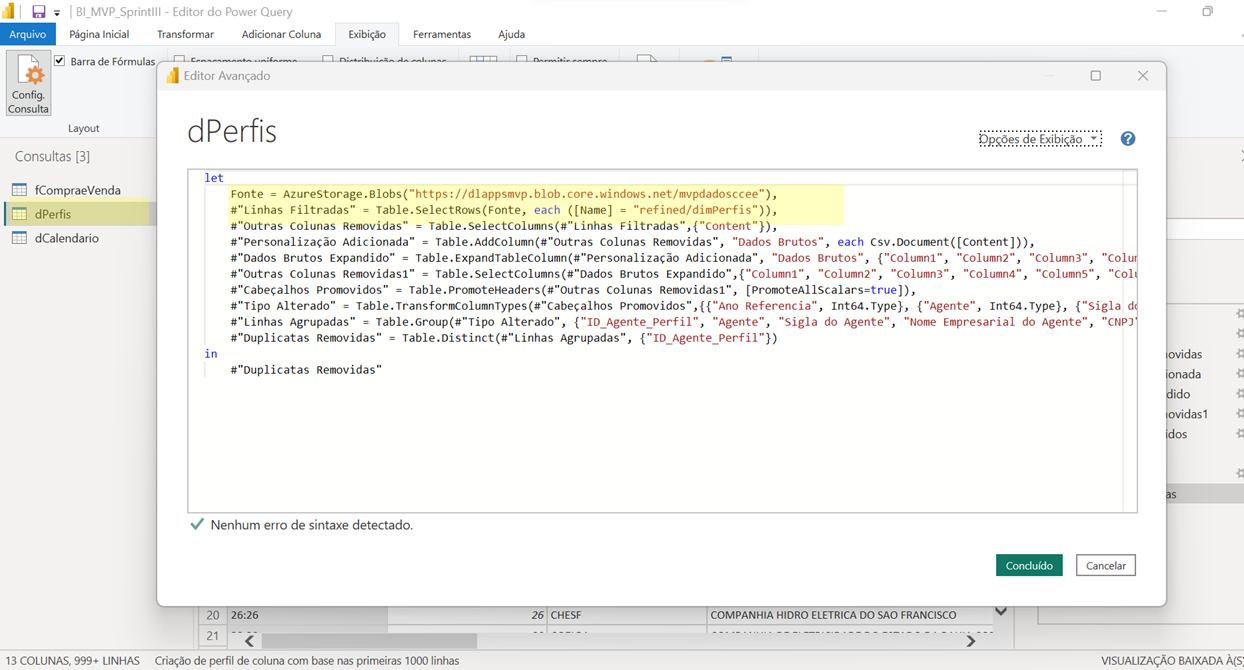

Para fins de enriquecimento da análise foi criada uma tabela adicional de dimensão denominada _dCalendario_, resultando assim no esquema estrela visualizado abaixo:

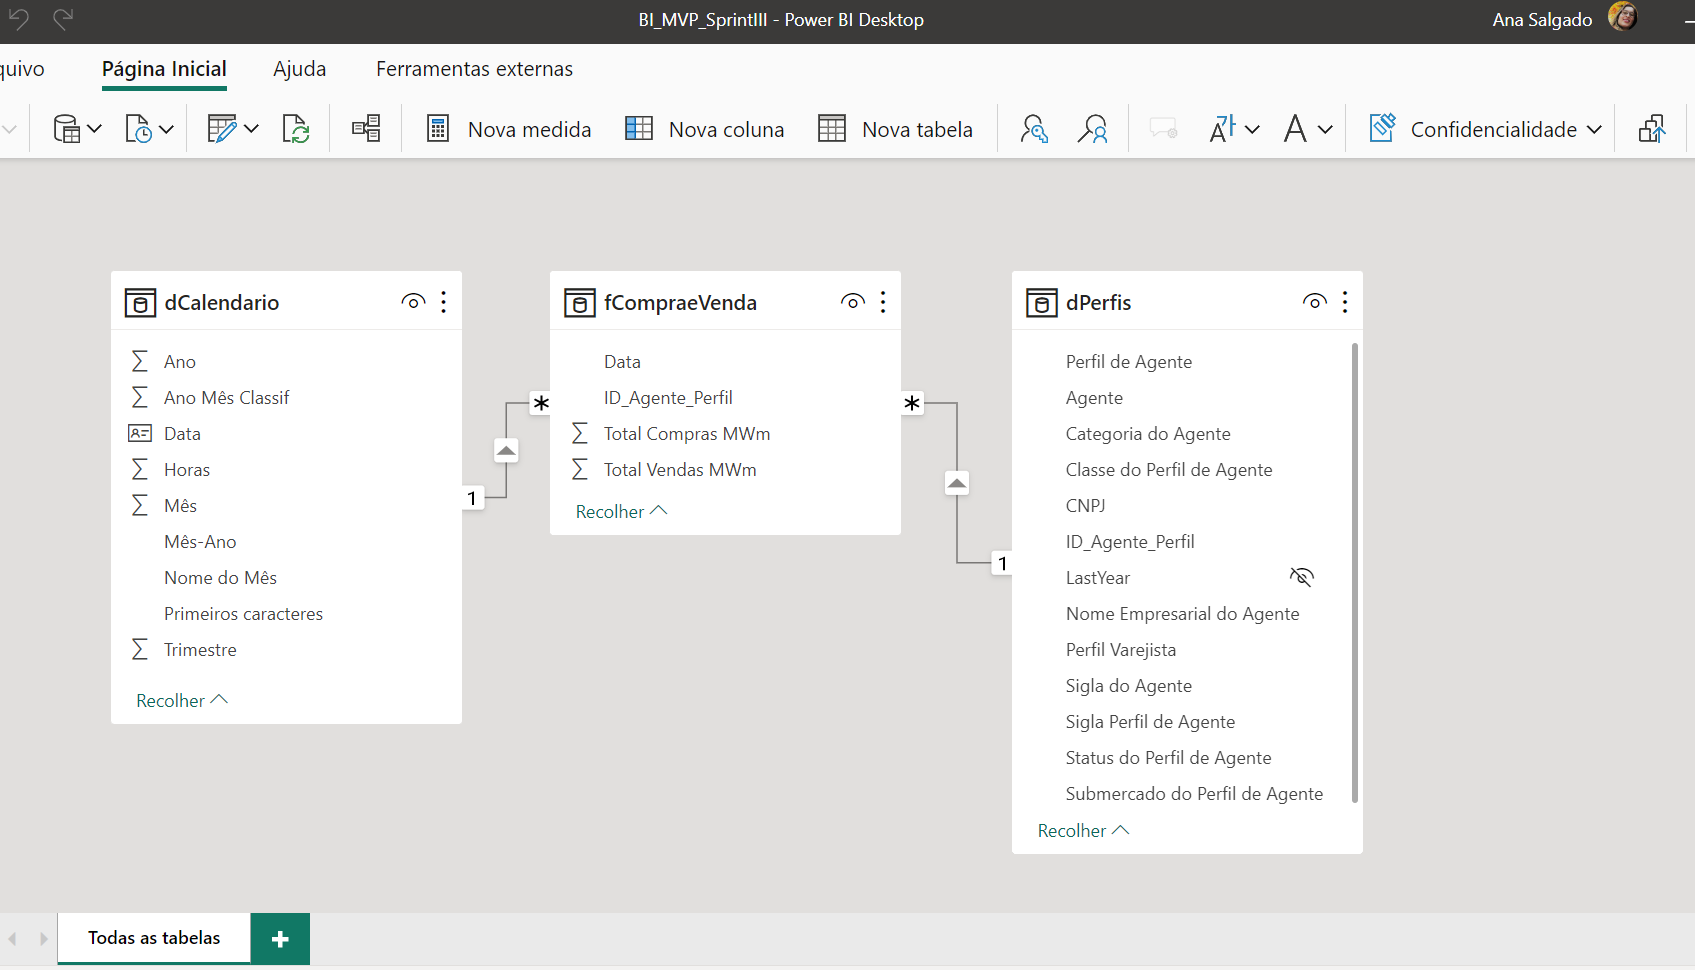

### Qualidade dos Dados

Em relação à qualidade dos dados, pontua-se que os campos relacionados aos volumes de compra e venda de energia elétrica, da tabela *fCompraeVenda*, originados da CCEE vêm nulos, quando não há movimentação no período, para estes casos foi adotada a substituição dos registros para o valor 0 (zero). As imagens a seguir exemplificam essa substituição executada no Powerquery e uma avaliação das colunas do dataset, com 100% dos valores válidos.

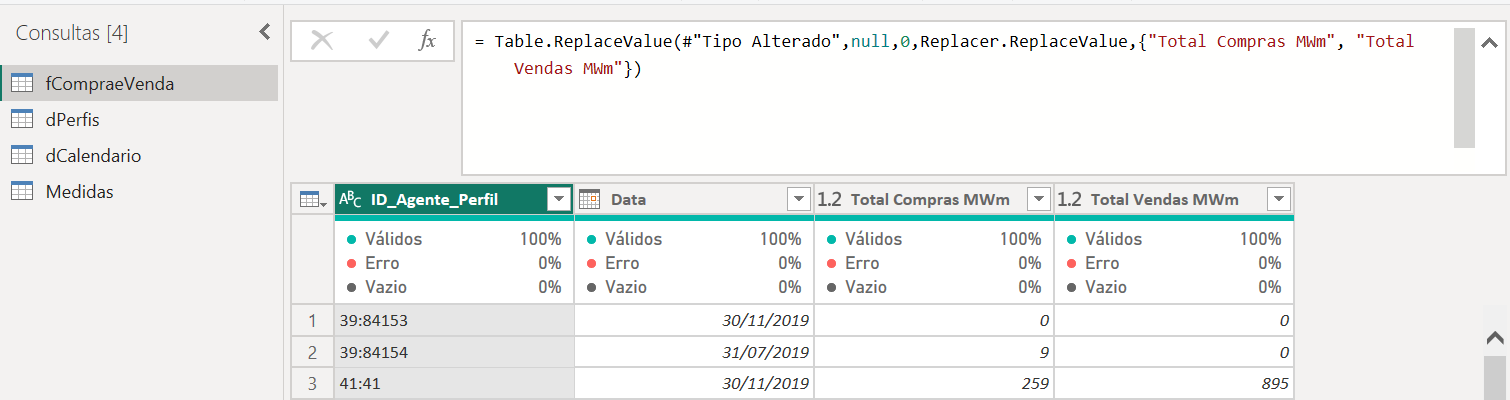


Com relação a tabela *dimPerfis* foram observados alguns campos sem informação no atributo 'Submercado', no entanto, como este campo não interfere nas análises ora propostas, nenhum tratamento foi necessário nesse momento.

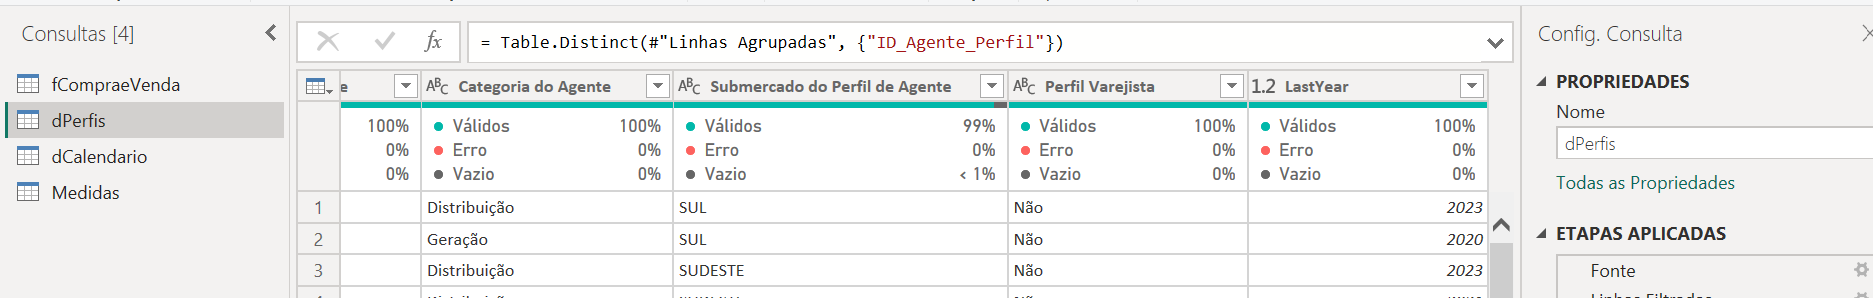

### Solução

A imagem do painel construído no Power BI busca evidenciar graficamente as respostas às questões elaboradas no tópico Objetivo, deste MVP.

Período: Janeiro/2019 a Julho/2023

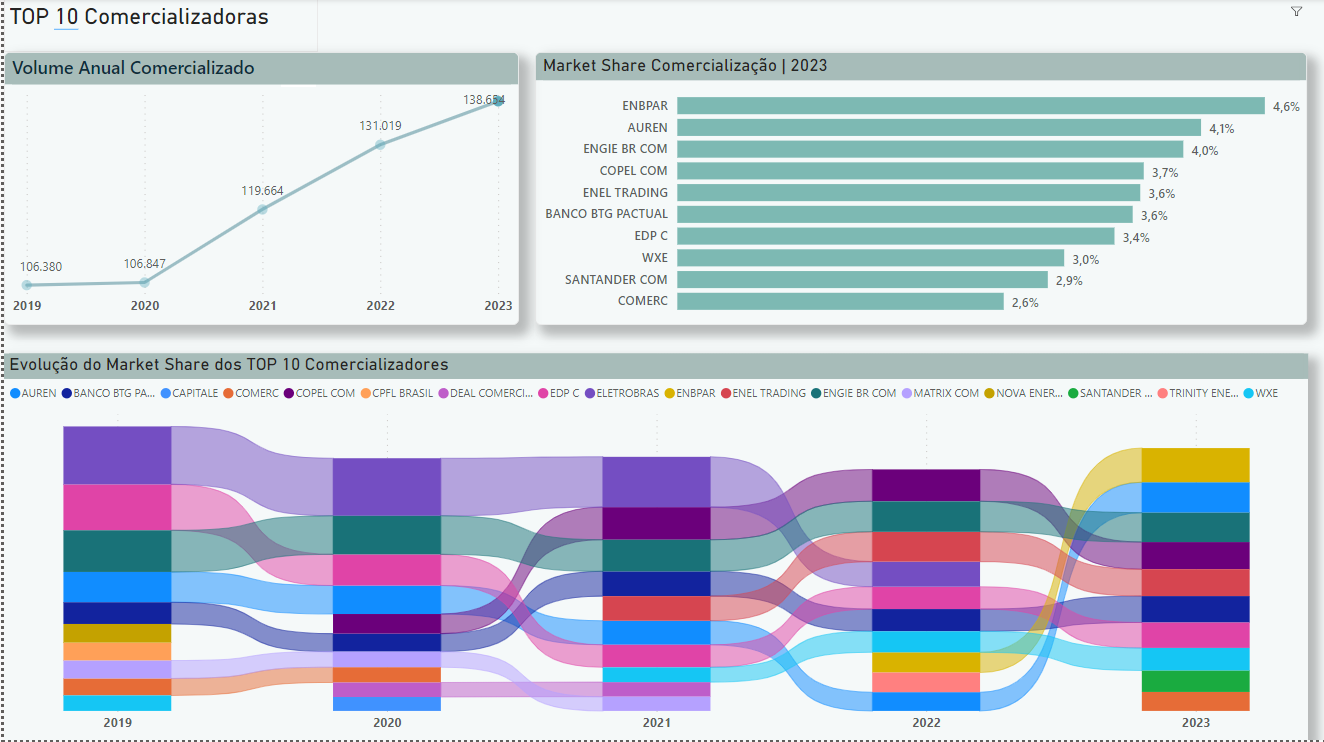

==>>> DISCORRER SOBRE A ANÁLISE DOS RESULTADOS OBTIDOS

# Conclusão